# Importing Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

import matplotlib.pyplot as plt

import os
import pandas as pd

from tensorflow.keras.applications import MobileNetV2
from keras.layers import AveragePooling2D , Dropout , Flatten , Dense , Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator , img_to_array , load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



from tensorflow.keras.models import load_model
from imutils.video import VideoStream

import imutils
import time
import cv2



In [ ]:
# Changing the Root Directory

ROOT = "/content/drive/MyDrive/MaskDetection"
os.chdir(ROOT)

# Data PreProcessing

In [ ]:
Dataset_Path = "/content/drive/MyDrive/MaskDetection/dataset"
Category = ["with_mask" , "without_mask"]



### Converting images to array

In [ ]:
data = []
labels = []

for category in Category:
  path = os.path.join(Dataset_Path , category)

  for img in os.listdir(path):
    img_path = os.path.join(path , img)
    image = load_img (img_path , target_size = (224 , 224))
    image = img_to_array (image)
    image = preprocess_input (image)

    data.append(image)
    labels.append(category)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
print(f"Total images  : {len(data)}")
print(f"Categories : {Category[0]}  , {Category[1]}")

Total images  : 3833
Categories : with_mask  , without_mask


###  Function to show images

In [ ]:
def show_image(index):
  plt.axis("off")
  plt.imshow(data[index])
  if(labels[index] == "with_mask" ):
    plt.title("With Mask")
  else: 
    plt.title("Without Mask")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


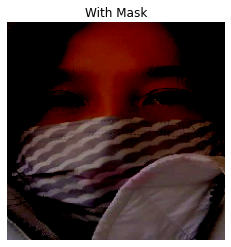

In [ ]:
show_image(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


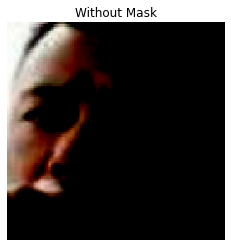

In [ ]:
show_image(2001)

### Applying One Hot Encoding

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [ ]:
data.shape

(3833, 224, 224, 3)

In [ ]:
data[0].ndim

3

In [ ]:
labels[0]

array([1., 0.], dtype=float32)

# Splitting the Dataset

In [ ]:
X_train , X_test , Y_train , Y_test = train_test_split(data , labels , random_state= 42)

In [ ]:
X_train.shape

(2874, 224, 224, 3)

In [ ]:
X_test.shape

(959, 224, 224, 3)

# Data Augemtation

In [ ]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# Training Model

In [ ]:
learning_rate = 1e-4
epochs = 20

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)


In [ ]:
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
optimizer = Adam(learning_rate = learning_rate, decay=  learning_rate/epochs)

In [ ]:
model.compile(loss="binary_crossentropy", 
                optimizer=optimizer,
	              metrics=["accuracy"])

In [ ]:
history = model.fit(
                      aug.flow(X_train, Y_train, batch_size=32),
                      validation_data=(X_test , Y_test),
                      epochs=epochs)

Epoch 1/20
90/90 [==============================] - 123s 1s/step - loss: 0.3897 - accuracy: 0.8688 - val_loss: 0.1415 - val_accuracy: 0.9791
Epoch 2/20
90/90 [==============================] - 119s 1s/step - loss: 0.1443 - accuracy: 0.9638 - val_loss: 0.0739 - val_accuracy: 0.9854
Epoch 3/20
90/90 [==============================] - 118s 1s/step - loss: 0.0995 - accuracy: 0.9753 - val_loss: 0.0564 - val_accuracy: 0.9823
Epoch 4/20
90/90 [==============================] - 119s 1s/step - loss: 0.0728 - accuracy: 0.9830 - val_loss: 0.0462 - val_accuracy: 0.9875
Epoch 5/20
90/90 [==============================] - 123s 1s/step - loss: 0.0623 - accuracy: 0.9833 - val_loss: 0.0412 - val_accuracy: 0.9875
Epoch 6/20
90/90 [==============================] - 123s 1s/step - loss: 0.0551 - accuracy: 0.9864 - val_loss: 0.0386 - val_accuracy: 0.9864
Epoch 7/20
90/90 [==============================] - 122s 1s/step - loss: 0.0501 - accuracy: 0.9836 - val_loss: 0.0337 - val_accuracy: 0.9906
Epoch 8/20
90

In [ ]:
model.save("mask_detector.model", save_format="h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
predictions = model.predict(X_test)

In [ ]:
predictions = np.argmax(predictions , axis = 1)

In [ ]:
print(classification_report(Y_test.argmax(axis=1), predictions, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.98      1.00      0.99       499
without_mask       1.00      0.98      0.99       460

    accuracy                           0.99       959
   macro avg       0.99      0.99      0.99       959
weighted avg       0.99      0.99      0.99       959



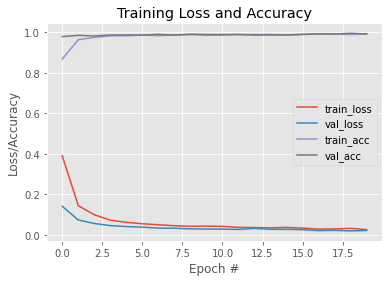

In [ ]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("plot.png")

# Realtime Detection

In [ ]:
def detect_and_predict_mask(frame, faceNet, maskNet):
	
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
		(104.0, 177.0, 123.0))

	
	faceNet.setInput(blob)
	detections = faceNet.forward()
	print(detections.shape)

	
	faces = []
	locs = []
	preds = []

	
	for i in range(0, detections.shape[2]):

		confidence = detections[0, 0, i, 2]

		if confidence > 0.5:
			
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			faces.append(face)
			locs.append((startX, startY, endX, endY))

	if len(faces) > 0:
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	return (locs, preds)

In [ ]:

prototxtPath = "/content/drive/MyDrive/MaskDetection/Face-Mask-Detection/face_detector/deploy.prototxt"
weightsPath = "/content/drive/MyDrive/MaskDetection/Face-Mask-Detection/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

maskNet = load_model("mask_detector.model")



In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab.patches import cv2_imshow
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

[INFO] starting video stream...


<IPython.core.display.Javascript object>

(1, 1, 200, 7)


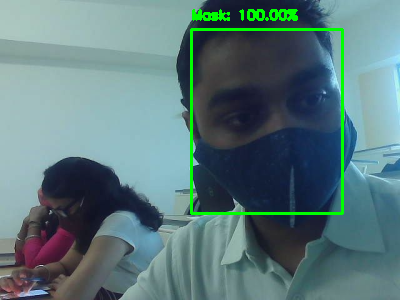

<IPython.core.display.Javascript object>

(1, 1, 200, 7)


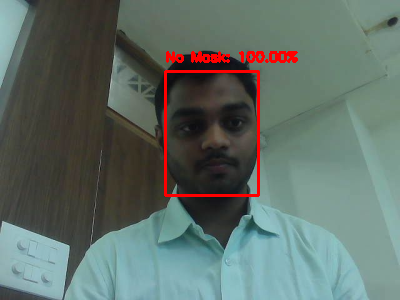

<IPython.core.display.Javascript object>

(1, 1, 200, 7)


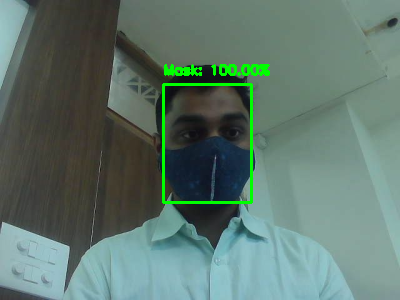

<IPython.core.display.Javascript object>

(1, 1, 200, 7)


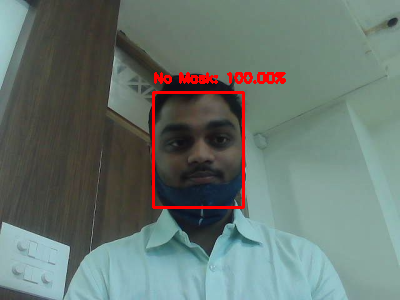

<IPython.core.display.Javascript object>

(1, 1, 200, 7)


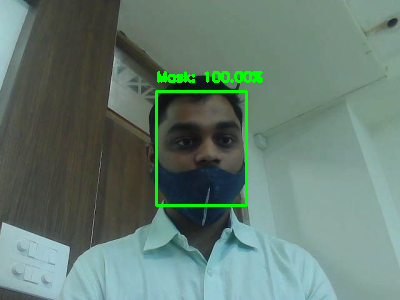

<IPython.core.display.Javascript object>

AttributeError: ignored

In [6]:

print("[INFO] starting video stream...")

while True:
	# grab the frame from the threaded video stream and resize it
	# to have a maximum width of 400 pixels
  frame = take_photo()
  frame = cv2.imread(frame)
  frame = imutils.resize(frame, width=400)
  (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

	# loop over the detected face locations and their corresponding
	# locations
  for (box, pred) in zip(locs, preds):
		# unpack the bounding box and predictions
    (startX, startY, endX, endY) = box
    (mask, withoutMask) = pred

		# determine the class label and color we'll use to draw
		# the bounding box and text
    label = "Mask" if mask > withoutMask else "No Mask"
    color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		
    label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		
    cv2.putText(frame, label, (startX, startY - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

	
  cv2_imshow( frame)
  key = cv2.waitKey(1) & 0xFF


  if key == ord("q"):
    break

cv2.destroyAllWindows()
vs.stop()